# ABU量化系统使用文档 

<center>
        <img src="./image/abu_logo.png" alt="" style="vertical-align:middle;padding:10px 20px;"><font size="6" color="black"><b>第17节 UMP边裁交易决策</b></font>
</center>

-----------------

作者: 阿布

阿布量化版权所有 未经允许 禁止转载

[abu量化系统github地址](https://github.com/bbfamily/abu) (欢迎+star)

[本节ipython notebook](https://github.com/bbfamily/abu/tree/master/abupy_lecture)

上一节示例了ump主裁的使用以及回测示例 本节将示例ump边裁交易决策, 首先导入abupy中本节使用的模块：

In [1]:
# 基础库导入

from __future__ import print_function
from __future__ import division

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys
# 使用insert 0即只使用github，避免交叉使用了pip安装的abupy，导致的版本不一致问题
sys.path.insert(0, os.path.abspath('../'))
import abupy

# 使用沙盒数据，目的是和书中一样的数据环境
abupy.env.enable_example_env_ipython()

enable example env will only read RomDataBu/df_kl.h5


In [2]:
from abupy import AbuFactorAtrNStop, AbuFactorPreAtrNStop, AbuFactorCloseAtrNStop, AbuFactorBuyBreak, ABuProgress
from abupy import abu, EMarketTargetType, AbuMetricsBase, ABuMarketDrawing, AbuFuturesCn, ABuSymbolPd, AbuOrderPdProxy
from abupy import AbuUmpMainDeg, AbuUmpMainJump, AbuUmpMainPrice, AbuUmpMainWave, AbuFuturesCn, EStoreAbu, AbuML
from abupy import AbuUmpEdgeDeg, AbuUmpEdgePrice, AbuUmpEdgeWave, AbuUmpEdgeFull

受限于沙盒中数据限制，本节示例的相关性分析只限制在abupy内置沙盒数据中，完整示例以及代码请阅读《量化交易之路》中相关章节。

和上一节一样首先将内置沙盒中美股，A股，港股, 比特币，莱特币，期货市场中的symbol都列出来，然后组成训练集和测试集，买入卖出因子等相同设置:

In [3]:
us_choice_symbols = ['usTSLA', 'usNOAH', 'usSFUN', 'usBIDU', 'usAAPL', 'usGOOG', 'usWUBA', 'usVIPS']
cn_choice_symbols = ['002230', '300104', '300059', '601766', '600085', '600036', '600809', '000002', '002594']
hk_choice_symbols = ['hk03333', 'hk00700', 'hk02333', 'hk01359', 'hk00656', 'hk03888', 'hk02318']
tc_choice_symbols = ['btc', 'ltc']
# 期货市场的直接从AbuFuturesCn().symbo中读取
ft_choice_symbols = AbuFuturesCn().symbol.tolist()

# 训练集：沙盒中所有美股 ＋ 沙盒中所有A股 ＋ 沙盒中所有港股 ＋ 比特币
train_choice_symbols = us_choice_symbols + cn_choice_symbols +  hk_choice_symbols + tc_choice_symbols[:1]
# 测试集：沙盒中所有期货 ＋ 莱特币
test_choice_symbols = ft_choice_symbols  + tc_choice_symbols[1:]

# 设置初始资金数
read_cash = 1000000
# 买入因子依然延用向上突破因子
buy_factors = [{'xd': 60, 'class': AbuFactorBuyBreak},
               {'xd': 42, 'class': AbuFactorBuyBreak}]

# 卖出因子继续使用上一节使用的因子
sell_factors = [
    {'stop_loss_n': 1.0, 'stop_win_n': 3.0,
     'class': AbuFactorAtrNStop},
    {'class': AbuFactorPreAtrNStop, 'pre_atr_n': 1.5},
    {'class': AbuFactorCloseAtrNStop, 'close_atr_n': 1.5}
]
# 回测生成买入时刻特征
abupy.env.g_enable_ml_feature = True

在运行完成第15节中相关内容后，使用load_abu_result_tuple读取第15节中保存在本地的训练集数据：

In [4]:
abu_result_tuple_train = abu.load_abu_result_tuple(n_folds=2, store_type=EStoreAbu.E_STORE_CUSTOM_NAME, 
                                             custom_name='lecture_train')
orders_pd_train = abu_result_tuple_train.orders_pd
AbuMetricsBase.show_general(*abu_result_tuple_train, returns_cmp=True, only_info=True)

买入后卖出的交易数量:196
买入后尚未卖出的交易数量:9
胜率:59.6939%
平均获利期望:18.6899%
平均亏损期望:-7.1235%
盈亏比:4.4972
所有交易收益比例和:16.2396 
所有交易总盈亏和:2717948.4900 


please wait! load_pickle....: /Users/Bailey/abu/data/cache/n2_lecture_train_capital
please wait! load_pickle....: /Users/Bailey/abu/data/cache/n2_lecture_train_benchmark


边裁核心代码在基类AbuUmpEdgeBase源代码中, 之所以称为边裁，是由于它的实现原理是通过统计训练集数据两端边缘胜负数据实现的，边裁的训练步骤很简单如下所示：

1. 将交易训练数据集根据获利比例进行排序
2. 找到top win、top loss，做上标记rk（比如把获利最多的25% rk＝1，亏损最多25% rk＝－1，其他rk＝0）

边裁比较复杂的地方在裁决方式上，它多次使用非均衡技术对最后的结果概率进行干预，目的是使最终的裁决正确率达成非均衡的目标，非均衡技术思想是量化中很很重要的一种设计思路，**因为我们量化的目标结果就是非均衡，我们想要赢的钱比输的多**。


更多详情实现请阅读AbuUmpEdgeBase源代码

### 1. 角度边裁

与主裁代码设计结构类似，子类完成的主要工作就是对特征进行处理，如AbuUmpEdgeDeg的特征为21、42、60、252日拟合角度，与主裁对特征处理的架构类似，主要区别如下：

1. 边裁特征不变区域为获利值(profit)与获利比例(profit_cg)。
2. 边裁make_xy()函数上的装饰器使用的为@ump_edge_make_xy，主裁使用@ump_main_make_xy，详情请查阅ABuUmpBase.py

下面不再分步讲解边裁的训练过程，与主裁类似直接使用类方法ump_edge_clf_dump完成主裁的训练和数据本地序列化操作：

In [5]:
edge_deg = AbuUmpEdgeDeg.ump_edge_clf_dump(orders_pd_train)
edge_deg.fiter.df.head()

please wait! dump_pickle....: /Users/Bailey/abu/data/ump/ump_edge_umpdegfiter


,profit,profit_cg,buy_deg_ang42,buy_deg_ang252,buy_deg_ang60,buy_deg_ang21,p_rk_cg,rk
2014-09-25,4368.00,0.0271,7.168,-3.708,4.342,2.255,99.0,0
2014-10-09,-11707.50,-0.0588,-0.567,-6.527,1.309,1.837,47.0,0
2014-10-17,23360.00,0.1170,2.328,4.764,2.096,2.357,142.0,0
2014-10-24,20410.88,0.1021,-0.454,5.532,2.142,0.931,137.5,0
2014-10-24,20410.88,0.1021,-0.454,5.532,2.142,0.931,137.5,0


上面所示的角度边裁除了profit和profit_cg与主裁使用的result不同外，多出了rk列，它代表了边裁的属性rk=1的交易为所有交易中表现最好的top个，rk=-1的交易为所有交易中表现最差的top个，如下可视化rk的比例：

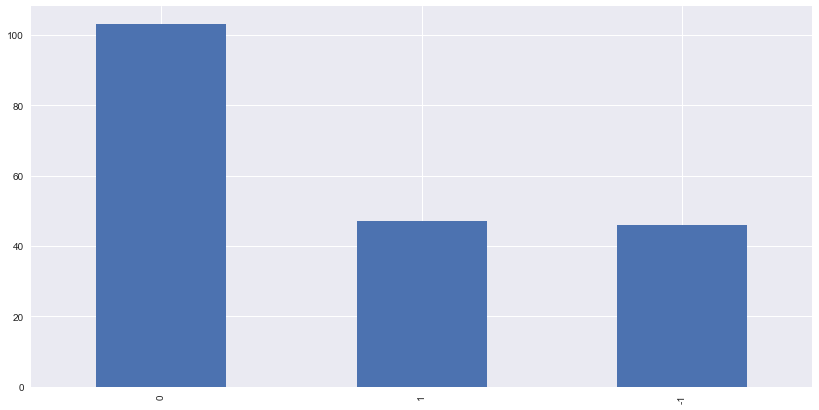

In [6]:
edge_deg.fiter.df.rk.value_counts().plot(kind='bar')

角度边裁与主裁的不同点，还多出了p_rk_cg列，它代表了交易最终收益的rank值，如下按照p_rk_cg排序，head即是所有交易中损失最大的5笔交易，显然它们的rk值也都是-1, 如下所示：

In [7]:
edge_deg.fiter.df.sort_values(by='p_rk_cg').head()

,profit,profit_cg,buy_deg_ang42,buy_deg_ang252,buy_deg_ang60,buy_deg_ang21,p_rk_cg,rk
2016-01-04,-16488.00,-0.2192,22.712,6.586,21.090,18.350,1.0,-1
2015-03-10,-18368.36,-0.1837,4.353,-31.744,-15.324,12.718,2.0,-1
2015-01-23,-15314.00,-0.1797,28.126,14.501,21.693,37.728,3.0,-1
2015-07-30,-13345.00,-0.1473,-0.450,21.599,-19.631,12.807,4.0,-1
2015-08-12,-16708.50,-0.1471,4.853,27.275,2.048,1.801,5.0,-1


相反tail即是所有交易中利润最大的5笔交易，显然它们的rk值也都是1, 如下所示：

In [8]:
edge_deg.fiter.df.sort_values(by='p_rk_cg').tail(5)

,profit,profit_cg,buy_deg_ang42,buy_deg_ang252,buy_deg_ang60,buy_deg_ang21,p_rk_cg,rk
2014-11-12,122126.0,0.6110,0.632,5.289,-1.389,2.873,191.5,1
2014-10-31,94207.5,0.6596,7.114,18.657,16.574,-0.098,193.5,1
2014-10-31,94207.5,0.6596,7.114,18.657,16.574,-0.098,193.5,1
2015-03-19,81188.5,0.7848,-0.406,33.161,26.840,6.430,195.0,1
2015-04-17,255794.0,1.2882,0.712,51.299,-0.378,1.357,196.0,1


### 2. 价格边裁

与角度边裁流程基本一致，下面训练价格边裁，输出为价格边裁特征：

In [9]:
edge_price = AbuUmpEdgePrice.ump_edge_clf_dump(orders_pd_train)
edge_price.fiter.df.head()

please wait! dump_pickle....: /Users/Bailey/abu/data/ump/ump_edge_umppricefiter


,profit,profit_cg,buy_price_rank120,buy_price_rank90,buy_price_rank60,buy_price_rank252,p_rk_cg,rk
2014-09-25,4368.00,0.0271,1.000,1.000,1.000,0.857,99.0,0
2014-10-09,-11707.50,-0.0588,0.992,0.989,0.983,0.798,47.0,0
2014-10-17,23360.00,0.1170,1.000,1.000,1.000,1.000,142.0,0
2014-10-24,20410.88,0.1021,1.000,1.000,1.000,1.000,137.5,0
2014-10-24,20410.88,0.1021,1.000,1.000,1.000,1.000,137.5,0


### 3. 波动边裁

下面训练波动边裁，输出为波动边裁特征：

In [10]:
edge_wave = AbuUmpEdgeWave.ump_edge_clf_dump(orders_pd_train)
edge_wave.fiter.df.head()

please wait! dump_pickle....: /Users/Bailey/abu/data/ump/ump_edge_umpwavefiter


,profit,profit_cg,buy_wave_score1,buy_wave_score2,buy_wave_score3,p_rk_cg,rk
2014-09-25,4368.00,0.0271,0.496,0.454,0.441,99.0,0
2014-10-09,-11707.50,-0.0588,0.230,0.072,-0.001,47.0,0
2014-10-17,23360.00,0.1170,0.743,0.374,0.232,142.0,0
2014-10-24,20410.88,0.1021,1.251,1.290,1.289,137.5,0
2014-10-24,20410.88,0.1021,1.251,1.290,1.289,137.5,0


### 4. 综合边裁

综合边裁AbuUmpEdgeFull为综合多种类型特征的裁判，如下所示：

In [11]:
edge_full = AbuUmpEdgeFull.ump_edge_clf_dump(orders_pd_train)
edge_full.fiter.df.head()

please wait! dump_pickle....: /Users/Bailey/abu/data/ump/ump_edge_umpfullfiter


,profit,profit_cg,buy_deg_ang42,buy_deg_ang252,buy_deg_ang60,buy_deg_ang21,buy_price_rank120,buy_price_rank90,buy_price_rank60,buy_price_rank252,buy_wave_score1,buy_wave_score2,buy_wave_score3,buy_atr_std,p_rk_cg,rk
2014-09-25,4368.00,0.0271,7.168,-3.708,4.342,2.255,1.000,1.000,1.000,0.857,0.496,0.454,0.441,1.159,99.0,0
2014-10-09,-11707.50,-0.0588,-0.567,-6.527,1.309,1.837,0.992,0.989,0.983,0.798,0.230,0.072,-0.001,1.281,47.0,0
2014-10-17,23360.00,0.1170,2.328,4.764,2.096,2.357,1.000,1.000,1.000,1.000,0.743,0.374,0.232,2.033,142.0,0
2014-10-24,20410.88,0.1021,-0.454,5.532,2.142,0.931,1.000,1.000,1.000,1.000,1.251,1.290,1.289,0.192,137.5,0
2014-10-24,20410.88,0.1021,-0.454,5.532,2.142,0.931,1.000,1.000,1.000,1.000,1.251,1.290,1.289,0.192,137.5,0


### 5 验证边裁是否称职


边裁裁决交易是否拦截的关键代码在函数AbuUmpEdgeBase.predict()中，边裁的predict()实现相对主裁来说比较复杂，大致思路如下：

1. 从输入的新交易中挑选需要的特征组成x
2. 将x和之前保存的训练集数据组合concatenate()，一起做数据标准化scaler
3. 使用sklearn.metrics.pairwise.pairwise_distances()度量输入特征和训练集矩阵中的距离序列
4. 取pairwise_distances() TOP个作为种子，继续匹配相似度
5. 相似度由大到小排序，保留大于保留阀值的相似度交易数据做为最终有投票权利的
6. 保留的交易认为是与新交易最相似的交易，保留的交易使用之前非均衡的rk对新交易进行投票
7. 最后的判断需要大于一定比例才被结果认可，即再次启动非均衡


本节开始时已介绍过边裁的裁决方式多次使用非均衡技术，对最后的结果概率进行干预，目的是使最终的裁决正确率达成非均衡的目标。
这里重复已达重视，即：
**非均衡技术思想是量化中很很重要的一种设计思路，因为我们量化的目标结果就是非均衡，我们想要赢的钱比输的多**。


具体代码实现请阅读AbuUmpEdgeBase.predict函数

备注：关于距离度量的应用阅读：第十四节 量化相关性分析应用)

首先和上一节一样使用训练集不使用边裁拦截情况下进行回测，如下所示：

In [12]:
# 不使用边裁拦截
abupy.env.g_enable_ump_edge_deg_block = False
abupy.env.g_enable_ump_edge_full_block = False
abupy.env.g_enable_ump_edge_price_block = False
abupy.env.g_enable_ump_edge_wave_block = False

abu_result_tuple_test, _ = abu.run_loop_back(read_cash,
                                                   buy_factors,
                                                   sell_factors,
                                                   start='2014-07-26',
                                                   end='2016-07-26',
                                                   choice_symbols=test_choice_symbols)
ABuProgress.clear_output()

In [13]:
AbuMetricsBase.show_general(*abu_result_tuple_test, returns_cmp=True, only_info=True)

买入后卖出的交易数量:247
胜率:41.2955%
平均获利期望:9.7208%
平均亏损期望:-4.8754%
盈亏比:1.3725
所有交易收益比例和:2.8459 
所有交易总盈亏和:428259.7700 


在abu系统中开启边裁进行拦截前，先分别量化一下每个裁判的拦截正确率，以及总拦截率。

下面编写apply_ml_features_edge()函数通过参数传入边裁，分别将四个边裁作为参数传入并对裁决结果进行记录：

In [14]:
import ast
def apply_ml_features_edge(order, predicter):
    if not isinstance(order.ml_features, dict):
        # 低版本pandas dict对象取出来会成为str
        ml_features = ast.literal_eval(order.ml_features)
    else:
        ml_features = order.ml_features
    # 边裁进行裁决
    edge = predicter.predict(**ml_features)
    return edge.value

# 选取有交易结果的数据order_has_result
order_has_result = abu_result_tuple_test.orders_pd[abu_result_tuple_test.orders_pd.result != 0]
# 角度边裁开始裁决
order_has_result['edge_deg'] = order_has_result.apply(
    apply_ml_features_edge, axis=1, args=(edge_deg,))

# 价格边裁开始裁决
order_has_result['edge_price'] = order_has_result.apply(
    apply_ml_features_edge, axis=1, args=(edge_price,))

# 综合边裁开始裁决
order_has_result['edge_full'] = order_has_result.apply(
    apply_ml_features_edge, axis=1, args=(edge_full,))

# 波动边裁开始裁决
order_has_result['edge_wave'] = order_has_result.apply(
    apply_ml_features_edge, axis=1, args=(edge_wave,))

please wait! load_pickle....: /Users/Bailey/abu/data/ump/ump_edge_umpdegfiter
please wait! load_pickle....: /Users/Bailey/abu/data/ump/ump_edge_umppricefiter
please wait! load_pickle....: /Users/Bailey/abu/data/ump/ump_edge_umpfullfiter
please wait! load_pickle....: /Users/Bailey/abu/data/ump/ump_edge_umpwavefiter


下面统计一下四个边裁总拦截数量以及拦截率：

In [15]:
block_pd = order_has_result.filter(regex='^edge_*')
"""
    由于predict返回的结果中1代表win top
    但是我们只需要知道loss_top，所以只保留-1, 其他1转换为0。
"""
block_pd['edge_block'] = \
    np.where(np.min(block_pd, axis=1) == -1, -1, 0)

# 拿出真实的交易结果
block_pd['result'] = order_has_result['result']
# 拿出-1的结果，即判定loss_top的
block_pd = block_pd[block_pd.edge_block == -1]

print('四个边裁拦截交易总数{}， 拦截率{:.2f}%'.format(
    block_pd.shape[0],
    block_pd.shape[0] / order_has_result.shape[0] * 100))
block_pd.head()

四个边裁拦截交易总数120， 拦截率48.58%


,edge_deg,edge_price,edge_full,edge_wave,edge_block,result
2014-09-25,0,-1,0,0,-1,-1
2014-10-10,0,0,0,-1,-1,-1
2014-10-30,0,0,0,-1,-1,-1
2014-10-30,0,-1,0,1,-1,-1
2014-11-04,0,-1,0,1,-1,-1


下面统计每一个边裁拦截正确率以及拦截数量：

In [16]:
from sklearn import metrics
def sub_edge_show(edge_name):
    sub_edge_block_pd = order_has_result[(order_has_result[edge_name] == -1)]
    accuracy = 0
    if sub_edge_block_pd.shape[0] > 0:
        accuracy = metrics.accuracy_score(sub_edge_block_pd[edge_name], sub_edge_block_pd.result) * 100
    return accuracy, sub_edge_block_pd.shape[0]

print('角度边裁拦截正确率{0:.2f}%, 拦截交易数量{1:}'.format(*sub_edge_show('edge_deg')))
print('综合边裁拦截正确率{0:.2f}%, 拦截交易数量{1:}'.format(*sub_edge_show('edge_full')))
print('波动边裁拦截正确率{0:.2f}%, 拦截交易数量{1:}'.format(*sub_edge_show('edge_wave')))
print('价格边裁拦截正确率{0:.2f}%, 拦截交易数量{1:}'.format(*sub_edge_show('edge_price')))

角度边裁拦截正确率55.56%, 拦截交易数量18
综合边裁拦截正确率0.00%, 拦截交易数量0
波动边裁拦截正确率61.67%, 拦截交易数量60
价格边裁拦截正确率63.89%, 拦截交易数量72


上面结果可以看到综合边裁没有能够拦截到一个交易，这是因为综合边裁使用的特征很多，但是测试集的交易数量太少，没有能在测试集中找到类似的交易特征描述。

### 6. 在abu系统中开启边裁拦截模式

验证边裁后就可以在回测或者实盘模块中开启边裁拦截，针对策略产生的交易信号进行买入拦截, 在之前针对测试集开启主裁拦截代码的基础上，我们开启边裁拦截开关：

In [17]:
# 开启边裁
abupy.env.g_enable_ump_edge_deg_block = True
abupy.env.g_enable_ump_edge_full_block = True
abupy.env.g_enable_ump_edge_price_block = True
abupy.env.g_enable_ump_edge_wave_block = True

abu_result_tuple_test_edge, _ = abu.run_loop_back(read_cash,
                                                   buy_factors,
                                                   sell_factors,
                                                   start='2014-07-26',
                                                   end='2016-07-26',
                                                   choice_symbols=test_choice_symbols)
ABuProgress.clear_output()

In [18]:
AbuMetricsBase.show_general(*abu_result_tuple_test_edge, returns_cmp=True, only_info=True)

买入后卖出的交易数量:127
胜率:44.8819%
平均获利期望:10.0347%
平均亏损期望:-5.1565%
盈亏比:1.4254
所有交易收益比例和:2.1103 
所有交易总盈亏和:245799.1100 


对比未开启边裁拦截的情况：

In [19]:
AbuMetricsBase.show_general(*abu_result_tuple_test, returns_cmp=True, only_info=True)

买入后卖出的交易数量:247
胜率:41.2955%
平均获利期望:9.7208%
平均亏损期望:-4.8754%
盈亏比:1.3725
所有交易收益比例和:2.8459 
所有交易总盈亏和:428259.7700 


如上所示使用边裁进行交易策略的拦截胜率，盈亏比相较上一节的主裁拦截都有所提高，且边裁拦截了大量的交易可以节省佣金，更重大的意义在于边裁避免了重大的风险，因为边裁的拦截目标是训练集top loss。

在实盘中往往根据资金量，策略并行数量等等因素计算出每日最佳交易数量，通过选股模块 ＋ ump模块使得每天实际交易数量逼近每日最佳交易数量，在之后的章节中会完整示例。

边裁的效果提升的方法与主裁类似，最为重要的依然是：**训练更多交易数据，更多策略来提升边裁的拦截水平及拦截认知范围，给每一个裁判看更多的比赛录像，提高比赛录像水准，如从多个不同视角录制比赛，这样裁判才能在实际比赛中做出最正确的判断。**

既然裁判都已经准备好了，那么就可以准备开始比赛了，[一定要赢得这场胜利，即使一切都不存在！](https://y.qq.com/n/yqq/song/0032b8613iuFFI.html)

小结：本节的示例与《量化交易之路》中讲解的边裁部分内容互为补充，请对照阅读。

#### abu量化文档目录章节

1. [择时策略的开发](http://www.abuquant.com/lecture/lecture_1.html)
2. [择时策略的优化](http://www.abuquant.com/lecture/lecture_2.html)
3. [滑点策略与交易手续费](http://www.abuquant.com/lecture/lecture_3.html)
4. [多支股票择时回测与仓位管理](http://www.abuquant.com/lecture/lecture_4.html)
5. [选股策略的开发](http://www.abuquant.com/lecture/lecture_5.html)
6. [回测结果的度量](http://www.abuquant.com/lecture/lecture_6.html)
7. [寻找策略最优参数和评分](http://www.abuquant.com/lecture/lecture_7.html)
8. [A股市场的回测](http://www.abuquant.com/lecture/lecture_8.html)
9. [港股市场的回测](http://www.abuquant.com/lecture/lecture_9.html)
10. [比特币，莱特币的回测](http://www.abuquant.com/lecture/lecture_10.html)
11. [期货市场的回测](http://www.abuquant.com/lecture/lecture_11.html)
12. [机器学习与比特币示例](http://www.abuquant.com/lecture/lecture_12.html)
13. [量化技术分析应用](http://www.abuquant.com/lecture/lecture_13.html)
14. [量化相关性分析应用](http://www.abuquant.com/lecture/lecture_14.html)
15. [量化交易和搜索引擎](http://www.abuquant.com/lecture/lecture_15.html)
16. [UMP主裁交易决策](http://www.abuquant.com/lecture/lecture_16.html)
17. [UMP边裁交易决策](http://www.abuquant.com/lecture/lecture_17.html)
18. [自定义裁判决策交易](http://www.abuquant.com/lecture/lecture_18.html)
19. [数据源](http://www.abuquant.com/lecture/lecture_19.html)
20. [A股全市场回测](http://www.abuquant.com/lecture/lecture_20.html)
21. [A股UMP决策](http://www.abuquant.com/lecture/lecture_21.html)
22. [美股全市场回测](http://www.abuquant.com/lecture/lecture_22.html)
23. [美股UMP决策](http://www.abuquant.com/lecture/lecture_23.html)

abu量化系统文档教程持续更新中，请关注公众号中的更新提醒。

#### 《量化交易之路》目录章节及随书代码地址

1. [第二章 量化语言——Python](https://github.com/bbfamily/abu/tree/master/ipython/第二章-量化语言——Python.ipynb)
2. [第三章 量化工具——NumPy](https://github.com/bbfamily/abu/tree/master/ipython/第三章-量化工具——NumPy.ipynb)
3. [第四章 量化工具——pandas](https://github.com/bbfamily/abu/tree/master/ipython/第四章-量化工具——pandas.ipynb)
4. [第五章 量化工具——可视化](https://github.com/bbfamily/abu/tree/master/ipython/第五章-量化工具——可视化.ipynb)
5. [第六章 量化工具——数学：你一生的追求到底能带来多少幸福](https://github.com/bbfamily/abu/tree/master/ipython/第六章-量化工具——数学.ipynb)
6. [第七章 量化系统——入门：三只小猪股票投资的故事](https://github.com/bbfamily/abu/tree/master/ipython/第七章-量化系统——入门.ipynb)
7. [第八章 量化系统——开发](https://github.com/bbfamily/abu/tree/master/ipython/第八章-量化系统——开发.ipynb)
8. [第九章 量化系统——度量与优化](https://github.com/bbfamily/abu/tree/master/ipython/第九章-量化系统——度量与优化.ipynb)
9. [第十章 量化系统——机器学习•猪老三](https://github.com/bbfamily/abu/tree/master/ipython/第十章-量化系统——机器学习•猪老三.ipynb)
10. [第十一章 量化系统——机器学习•ABU](https://github.com/bbfamily/abu/tree/master/ipython/第十一章-量化系统——机器学习•ABU.ipynb)
11. [附录A 量化环境部署](https://github.com/bbfamily/abu/tree/master/ipython/附录A-量化环境部署.ipynb)
12. [附录B 量化相关性分析](https://github.com/bbfamily/abu/tree/master/ipython/附录B-量化相关性分析.ipynb)
13. [附录C 量化统计分析及指标应用](https://github.com/bbfamily/abu/tree/master/ipython/附录C-量化统计分析及指标应用.ipynb)

[更多阿布量化量化技术文章](http://www.abuquant.com/article)


更多关于量化交易相关请阅读[《量化交易之路》](http://www.abuquant.com/books/quantify-trading-road.html)

更多关于量化交易与机器学习相关请阅读[《机器学习之路》](http://www.abuquant.com/books/machine-learning-road.html)

更多关于abu量化系统请关注微信公众号: abu_quant

![](./image/qrcode.jpg)